<a href="https://colab.research.google.com/github/chaecheche/mywork/blob/main/try1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#제반 작업

In [ ]:
# Hyperparameters
CONFIG = {
    'lr': 0.01,
    'epochs': 10,
    'min_batch': 32,
    'weight_decay': 1e-4
}

In [ ]:
import torch
from torch import nn
import numpy as np
import tensorflow as tf
from google.colab import drive, output
drive.mount("/content/gdrive")
import scipy.io.wavfile as wav
!pip install keras
from tensorflow import keras
import torch.optim as optim
output.clear()

In [ ]:
!pip install python_speech_features
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from python_speech_features import mfcc, logfbank
import librosa
from tqdm import tqdm
import pickle
import os
from torchsummary import summary
m_path = "/content/gdrive/MyDrive/Audio Classification/audio_train" #디렉토리 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
output.clear()

In [ ]:
X_path = "/content/gdrive/MyDrive/24w_deepdaiv/week2/X_whole.npy"
y_path = "/content/gdrive/MyDrive/24w_deepdaiv/week2/y_whole.npy"
X_data = np.load(X_path)
y_data = np.load(y_path)

X_len = X_data.shape[0]
train_size = 0.7
idx = np.random.permutation(X_len)
train_idx = idx[:round(train_size*X_len)]; test_idx = idx[round(train_size*X_len):]
X_train = X_data[train_idx].astype(np.float32); X_test = X_data[test_idx].astype(np.float32);
y_train = y_data[train_idx].astype(np.float32); y_test = y_data[test_idx].astype(np.float32);

# 전처리

In [ ]:
X_data.shape

(54979, 13, 49)

In [ ]:
# 정규화
X_data_normalized = (X_data - np.mean(X_data)) / np.std(X_data)

# 테스트 데이터에 대해서도 동일하게 적용
X_test_max = X_test.max(axis=(1, 2), keepdims=True)
X_test_min = X_test.min(axis=(1, 2), keepdims=True)
X_test_scaled = (X_test - X_test_min) / (X_test_max - X_test_min)

In [ ]:
# 표준화
def standardize_data(X):
    # 평균과 표준편차 계산
    mean = X.mean(axis=(1, 2), keepdims=True)
    std = X.std(axis=(1, 2), keepdims=True)
    # 표준화 수행
    X_standardized = (X - mean) / (std + 1e-10) # 0으로 나누는 것을 방지하기 위해 작은 값 추가
    return X_standardized

# 훈련 데이터와 테스트 데이터에 표준화 적용
X_train_standardized = standardize_data(X_train)
X_test_standardized = standardize_data(X_test)

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_data_normalized, y_data, test_size=0.2, random_state=42)


In [ ]:
# tensorflow keras 사용
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
688/688 [==============================] - 10s 11ms/step - loss: 1.5188 - accuracy: 0.4936
Epoch 2/50
688/688 [==============================] - 9s 13ms/step - loss: 1.0819 - accuracy: 0.6459
Epoch 3/50
688/688 [==============================] - 9s 13ms/step - loss: 0.9029 - accuracy: 0.7064
Epoch 4/50
688/688 [==============================] - 8s 12ms/step - loss: 0.7951 - accuracy: 0.7420
Epoch 5/50
688/688 [==============================] - 9s 13ms/step - loss: 0.7134 - accuracy: 0.7664
Epoch 6/50
688/688 [==============================] - 8s 12ms/step - loss: 0.6563 - accuracy: 0.7851
Epoch 7/50
688/688 [==============================] - 9s 13ms/step - loss: 0.6043 - accuracy: 0.7987
Epoch 8/50
688/688 [==============================] - 9s 14ms/step - loss: 0.5567 - accuracy: 0.8132
Epoch 9/50
688/688 [==============================] - 8s 12ms/step - loss: 0.5351 - accuracy: 0.8204
Epoch 10/50
688/688 [==============================] - 10s 14ms/step - loss: 0.4988 - accu

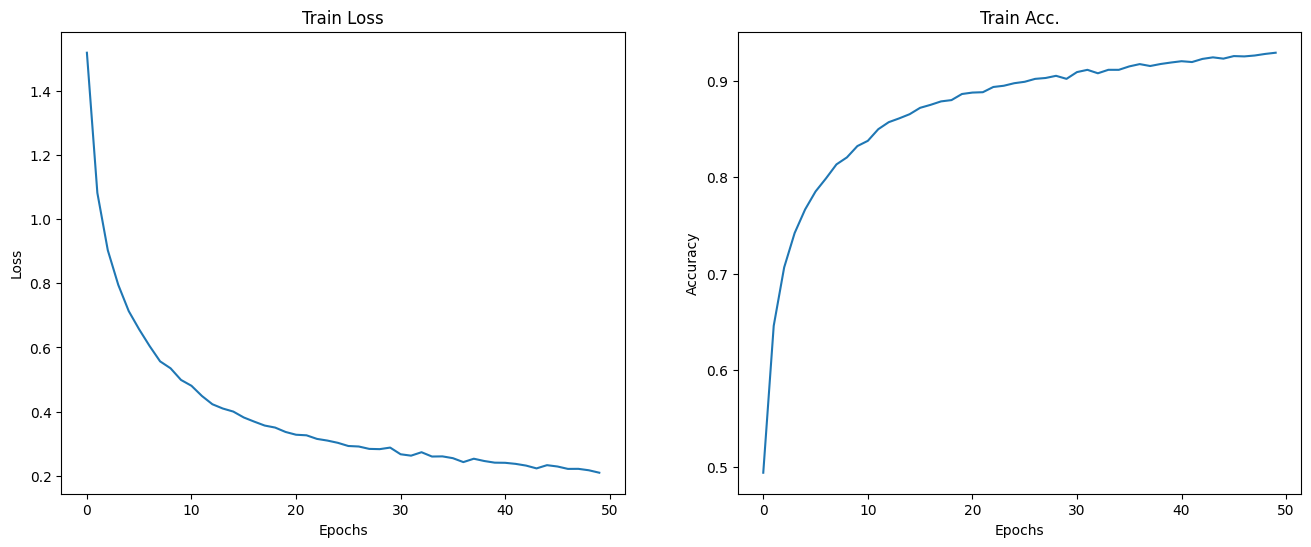

In [ ]:
import matplotlib.pyplot as plt


def plot_history(history):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.title("Train Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.title("Train Acc.")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

plot_history(history)

In [ ]:
model.evaluate(X_test, y_test, batch_size=64)

172/172 [==============================] - 2s 7ms/step - loss: 0.5785 - accuracy: 0.8823


[0.5784502029418945, 0.8823208212852478]

#모델 평가 (Keras)

In [ ]:
os.getcwd()

'/content'

In [ ]:
model.save("model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#학습했던 모델들 불러오기
orig_model = keras.models.load_model("model.h5")

In [ ]:
#원본 데이터로 학습한 모델을 실험 데이터로 평가
orig_pred = orig_model.predict(X_test)
cce = tf.keras.losses.CategoricalCrossentropy()
print("The categorical crossentropy loss of the original model is :",  cce(y_test, orig_pred).numpy())

344/344 [==============================] - 1s 4ms/step
The categorical crossentropy loss of the original model is : 0.54989916


In [ ]:
#0.5초의 데이터에 대해서 한번의 예측을 하는 코드 작성
classes = ["Acoustic_guitar", "Bass_drum", "Cello", "Clarinet",
           "Double_bass", "Snare_drum", "Electric_piano", "Flute",
           "Harmonica", "Hi-hat", "Oboe", "Saxophone", "Trumpet", "Violin_or_fiddle"] #분류의 대상인 14개 클래스


def evaluate_once(model):
  step = int(44100 * 0.5)
  rand_class = np.random.choice(classes)
  dirname = str(np.random.choice(df[df.label == rand_class]["fname"]))
  y, sr = librosa.load("/content/gdrive/MyDrive/Audio Classification/audio_train/"+dirname, sr = 44100)

  label = df.loc[df["fname"] == dirname, "label"].item()

  start_idx = np.random.randint(0, (y.shape[0] - step))
  sample = y[start_idx:start_idx + step]
  X_sample = mfcc(sample, sr, numcep = 13, nfilt = 26, nfft = 1103).T
  X_sample = np.array([X_sample]) #차원을 (1, 13, 17)로 만들기 위함
  pred = model.predict(X_sample)

  ans = np.argmax(pred)  #argmax는 1d array에서 가장 큰 값의 순서 인덱스를 반환한다. ex) np.argmax([1, 5, 2]) = 1
  #softmax를 출력층에 활용하는 모델이기에 predict 시 10개의 라벨들 중 특정 라벨에 속할 확률을 모델링한다. 그들 중 가장 확률이 높은 값을 결과로 출력하기 위해 argmax를 수행한다.
  pred_label = classes[ans] #pred_label은 classes라는 list객체 내에 있는 라벨 문자열, 즉 예측된 악기명을 의미한다.

  print("predictions: ", pred_label, "real value: ", label)
  return Audio(data = sample, rate = sr)

In [ ]:
evaluate_once(orig_model)

NameError: name 'df' is not defined